# 1. Raw Data

### 1.1 Create DB Conncection

In [153]:
import db_connect
sql = db_connect.DatabaseConnect('CS581GROUP6','localhost','root','qwerty','3306')

# 2. Preprocessing

In [154]:
from datetime import datetime
from datetime import timedelta  
import numpy as np
import pandas as pd

In [155]:
max_delay_percent = 0.25
max_delay = 600
max_walking_time_percent = 0.10
max_walking_time = 240

pool_duration = 5

### 2.1 Mapping Coordinates to Destination ID

In [156]:
def getdestid(lat,longt):
    return df_destinations.iloc[df_destinations.apply(lambda x: np.linalg.norm(np.array([lat, longt]) - np.array([x['destLat'],x['destLong']])), axis=1).idxmin(axis = 0)]['destID']

In [157]:
def search_map_dest_id(lat_start, lat_end, long_start, long_end, dest_lat, dest_long, num_of_iter, num_of_iter_limit):
    
    if lat_start + (lat_end - lat_start)/2 >= dest_lat:
        lat_end = lat_start + (lat_end - lat_start)/2
    else:
        lat_start = lat_start + (lat_end - lat_start)/2

    if long_start + (long_end - long_start)/2 >= dest_long:
        long_end = long_start + (long_end - long_start)/2
    else:
        long_start = long_start + (long_end - long_start)/2
    num_of_iter = num_of_iter + 1
    if num_of_iter <= num_of_iter_limit:
        return search_map_dest_id(lat_start, lat_end, long_start, long_end, dest_lat, dest_long, num_of_iter,num_of_iter_limit)

    else:
        filtered_dest = df_destinations.loc[(df_destinations['destLat'] >= lat_start) & (df_destinations['destLat'] <= lat_end) & (df_destinations['destLong'] >= long_start) & (df_destinations['destLong'] <= long_end)]
        if len(filtered_dest) == 0:
            return False
        else:    
            return df_destinations.iloc[filtered_dest.apply(lambda x: np.linalg.norm(np.array([dest_lat,dest_long]) - np.array([x['destLat'],x['destLong']])), axis=1).idxmin(axis = 0)]['destID']

### 2.2 Pool Window Assignment

In [158]:
def getPoolWindow(pickup_time, pool_start_time, pool_window_id):
    
    pool_end_time = pool_start_time + timedelta(minutes = pool_duration)
    
    if(pickup_time > pool_end_time):
        
        pool_window_id += 1
    
        while(pickup_time > pool_end_time):

            pool_start_time += timedelta(minutes = pool_duration)
            pool_end_time = pool_start_time + timedelta(minutes = pool_duration)
                
    return pool_start_time, pool_window_id

def poolWindowAssignment():
    
    pool_window_id = 1 
    pool_start_time = df['tpep_pickup_datetime'][0]
    pool_window_id_list = []
    req_pool_window_id_list = []
    pool_start_time_list = []
    pool_window_duration_list = []
    
    i = 0
    pool_window_id_list.append(pool_window_id)
    pool_start_time_list.append(pool_start_time)
    pool_window_duration_list.append(pool_duration)
    
    for pickup_datetime in df.tpep_pickup_datetime:
        
        pool_start_time, pool_window_id = getPoolWindow(pickup_datetime, pool_start_time, pool_window_id)
        req_pool_window_id_list.append(pool_window_id)

        #print('pool_window_id_list[',i,'] ',pool_window_id_list[i],' pool_window_id: ',pool_window_id)
        if(pool_window_id_list[i] != pool_window_id):
            pool_window_id_list.append(pool_window_id)
            pool_start_time_list.append(pool_start_time)
            pool_window_duration_list.append(pool_duration)
            i += 1
    
    df['pool_window_id'] = req_pool_window_id_list

    pool_window_data = {'poolingWindowID': pool_window_id_list, 'poolingStartTime': pool_start_time_list, 'poolingDuration': pool_window_duration_list}
    pool_window_df = pd.DataFrame(data=pool_window_data)
    return pool_window_df

### 2.3 Calculate Ride Time

In [159]:
def getRideTime(time):
    time = sec_to_min(time.seconds)
    return time

### 2.4 Calculate Delay

In [160]:
def getDelay(pickupTime, dropoffTime):
    tripTime = (dropoffTime - pickupTime).seconds
    trip_percent = tripTime * max_delay_percent
    return min(trip_percent, max_delay)

### 2.5 Calculate Walking Time

In [161]:
def getWalkingTime(pickupTime, dropoffTime):
    tripTime = (dropoffTime - pickupTime).seconds
    trip_percent = tripTime * max_walking_time_percent
    return min(trip_percent, max_walking_time)

### 2.6 Calculate Cost for Individual Ride

In [162]:
def sec_to_min(sec_time):
    return sec_time/60

In [163]:
def meter_to_mile(meter_distance):
    return meter_distance/1609.34

In [164]:
def cost_function(distance, time, isSharedTrip):
    #Convert milliseconds to minutes
    time = sec_to_min(time.seconds)
    #Convert meters to miles
    #distance = meter_to_mile(distance)
    if isSharedTrip:
        cost_per_mile = 1.00
        cost_per_min = 0.18
    else:
        cost_per_mile = 1.80
        cost_per_min = 0.28
    base_fare = 0
    booking_fee = 2.3
    min_fare = 7.3
    #print(distance, time)
    total_fare = (cost_per_mile * distance) + (cost_per_min * time) + base_fare + booking_fee + min_fare
    return total_fare

# Execute Preprocessing

In [167]:
df = pd.read_csv('RideSharingData/filtered_data2.csv')
df_destinations = sql.query('select * from destination',True)

df['tpep_pickup_datetime'] = [datetime.strptime(pickup_time, '%Y-%m-%d %H:%M:%S') 
                                          for pickup_time in df['tpep_pickup_datetime']]

df['tpep_dropoff_datetime'] = [datetime.strptime(dropoff_time, '%Y-%m-%d %H:%M:%S') 
                                          for dropoff_time in df['tpep_dropoff_datetime']]
import time
start_time = time.time()
#df['destination_id'] = df.iloc[:1000].apply(lambda x: getdestid(x['dropoff_latitude'],x['dropoff_longitude']),axis = 1)
df['destID'] = df.apply(lambda x: search_map_dest_id(40.69134374000000000000, 40.88140500000000000000, -74.04164664000000000000, -73.87790573000000000000, x['dropoff_latitude'], x['dropoff_longitude'], 0, 5),axis = 1)
elapsed_time = time.time() - start_time
print(elapsed_time)

df['indvRideTime'] = df.apply(lambda x: getRideTime(x['tpep_dropoff_datetime']-x['tpep_pickup_datetime']),axis = 1)
df['indvRideCost'] = df.apply(lambda x: cost_function(x['trip_distance'],x['tpep_dropoff_datetime']-x['tpep_pickup_datetime'], False),axis = 1)
df['maxDelay'] = df.apply(lambda x: getDelay(x['tpep_pickup_datetime'],x['tpep_dropoff_datetime']),axis = 1)
df['maxWalkTime'] = df.apply(lambda x: getWalkingTime(x['tpep_pickup_datetime'],x['tpep_dropoff_datetime']),axis = 1)

#cost_function(df['trip_distance'], df['tpep_dropoff_datetime']-df['tpep_pickup_datetime'], False)

387.73109793663025


In [178]:
import time
start_time = time.time()
df.loc[df['destID']==False,'destID']=df.loc[df['destID']==False].apply(lambda x: search_map_dest_id(40.69134374000000000000, 40.88140500000000000000, -74.04164664000000000000, -73.87790573000000000000, x['dropoff_latitude'], x['dropoff_longitude'], 0, 0),axis = 1)
elapsed_time = time.time() - start_time
print(elapsed_time)

11.399413108825684


In [179]:
df.loc[df['destID']==False]

,Unnamed: 0,Unnamed: 0.1,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,dropoff_longitude,dropoff_latitude,total_amount,isWillingToWalk,numberOfPassengers,destID,indvRideTime,indvRideCost,maxDelay,maxWalkTime,reqID,pool_window_id


# 3. DF_Request Table

In [172]:
pool_window_df = poolWindowAssignment()

In [177]:
df['reqID'] =  df.index + 1
request_df = df[['reqID', 'numberOfPassengers', 'isWillingToWalk', 'destID', 'maxDelay','maxWalkTime','tpep_pickup_datetime','indvRideTime','trip_distance','indvRideCost','pool_window_id']].copy()

In [183]:
request_df=request_df.rename(index=str, columns={'tpep_pickup_datetime':'requestTime','trip_distance':'indvRideDist','pool_window_id':'poolingWindowID'})

In [184]:
request_df

,reqID,numberOfPassengers,isWillingToWalk,destID,maxDelay,maxWalkTime,requestTime,indvRideTime,indvRideDist,indvRideCost,poolingWindowID
0,1,2,1,DEST2384,457.50,183.0,2016-01-02 00:47:06,30.500000,18.27,51.026000,1
1,2,1,1,DEST3174,438.25,175.3,2016-01-02 00:47:33,29.216667,21.36,56.228667,1
2,3,1,0,DEST2802,369.75,147.9,2016-01-02 00:47:39,24.650000,18.66,50.090000,1
3,4,2,0,DEST2245,414.75,165.9,2016-01-02 00:47:57,27.650000,18.60,50.822000,1
4,5,1,0,DEST3175,464.00,185.6,2016-01-02 00:48:13,30.933333,20.50,55.161333,1
5,6,1,1,DEST1396,498.75,199.5,2016-01-02 00:48:36,33.250000,19.45,53.920000,1
6,7,1,0,DEST2383,433.75,173.5,2016-01-02 00:49:03,28.916667,17.87,49.862667,1
7,8,2,1,DEST2099,412.00,164.8,2016-01-02 00:50:05,27.466667,17.70,49.150667,1
8,9,1,1,DEST1916,522.00,208.8,2016-01-02 00:51:19,34.800000,21.15,57.414000,1
9,10,2,1,DEST1958,444.00,177.6,2016-01-02 00:51:33,29.600000,20.20,54.248000,1


# 4. Insert into SQL DB

In [104]:
#pool_window_df
sql.insert(pool_window_df,'POOLING_WINDOW');

In [194]:
sql.insert(request_df,'REQUESTS');

Exception: 

# Exceptions

In [191]:
df_q = pd.merge(df_destinations, request_df, on='destID', how='inner')

In [193]:
df_q.dtypes

destID                        object
destLat                      float64
destLong                     float64
timeFromSrc                   object
distFromSrc                  float64
reqID                          int64
numberOfPassengers             int64
isWillingToWalk                int64
maxDelay                     float64
maxWalkTime                  float64
requestTime           datetime64[ns]
indvRideTime                 float64
indvRideDist                 float64
indvRideCost                 float64
poolingWindowID                int64
dtype: object

In [132]:
df.loc[df['total_amount']>500]

,Unnamed: 0,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,dropoff_longitude,dropoff_latitude,total_amount,destID,isWillingToWalk,reqID
39308,3630019,2016-01-16 22:15:13,2016-01-16 22:56:45,1,17.6,-73.987373,40.759491,952.90,NaN,1,39309
67131,5966724,2016-01-27 16:49:20,2016-01-27 17:52:15,1,18.7,-73.979858,40.729481,938.39,NaN,1,67132
85350,7594285,2016-01-30 20:24:39,2016-01-30 21:04:01,3,17.5,-73.971405,40.756077,724.82,NaN,1,85351


In [65]:
df.loc[df['total_amount']<0]

,Unnamed: 0,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,dropoff_longitude,dropoff_latitude,total_amount,destination_id,cost
94030,8508970,2016-01-21 12:04:53,2016-01-21 13:35:06,3,0.01,-73.985809,40.763363,-70.0,NaN,12.144067


In [106]:
df.loc[df['indvRideCost']>400]

KeyError: 'cost'

In [114]:
df.loc[df['indvRideTime']>360].size

3324

# Actual Individual Cost vs Calculated Individual Cost

Current size: [16.0, 10.0]


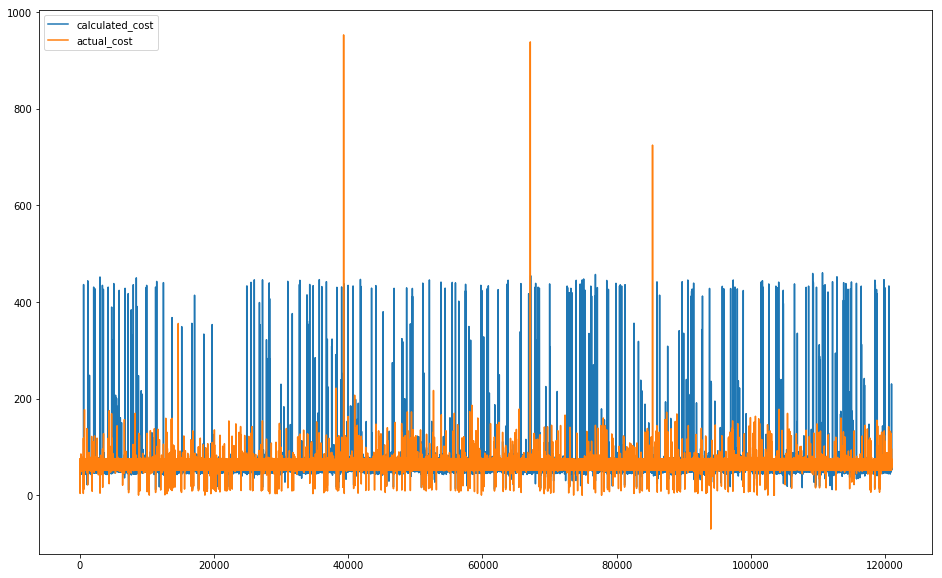

In [76]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(df))


# Get current size
fig_size = plt.rcParams["figure.figsize"]
 
# Prints: [8.0, 6.0]
print ("Current size:", fig_size)
# Set figure width to 12 and height to 9
fig_size[0] = 16
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size


plt.plot(x, df['cost'])
plt.plot(x, df['total_amount'])

plt.legend(['calculated_cost','actual_cost'], loc='upper left')
plt.show()

# 4. Shareability Graph

### For each pool

In [ ]:
def getRequestListForEachPoolId():
    max_pool_window_id = df['pool_window_id'].max()
    all_req_list = []
    each_pool_req_list = []
    
    for x in range(1,  max_pool_window_id  ):
        each_pool_req_list = df.loc[df['pool_window_id'] == x]
        all_req_list.append(each_pool_req_list)
    return all_req_list

In [ ]:
def sharability_graph(all_req_t_slot_1):
    
    taxi_capacity = 3
    for reqA in all_req_t_slot_1:
        for reqB in all_req_t_slot_1:
            if reqA != reqB and reqA.no_of_passengers + reqB.no_of_passengers <= taxi_capacity:

                reqA_orgin_dest_dist = Destination(reqA.dest_id).calculate_dist_from_src()
                reqB_orgin_dest_dist = Destination(reqB.dest_id).calculate_dist_from_src()
                
                #print('reqA_orgin_dest_dist: ',reqA_orgin_dest_dist)
                #print('reqB_orgin_dest_dist: ',reqB_orgin_dest_dist)
                
             
           

In [ ]:
def sharability_graph(df):
    
    taxi_capacity = 3
    for reqA in df:
        for reqB in df:
            if reqA != reqB and reqA.no_of_passengers + reqB.no_of_passengers <= taxi_capacity:

                reqA_orgin_dest_dist = Destination(reqA.dest_id).calculate_dist_from_src()
                reqB_orgin_dest_dist = Destination(reqB.dest_id).calculate_dist_from_src()
                
                #print('reqA_orgin_dest_dist: ',reqA_orgin_dest_dist)
                #print('reqB_orgin_dest_dist: ',reqB_orgin_dest_dist)
                
             
           